In [1]:
import tensorflow as tf

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.set_visible_devices(physical_devices[1:],'GPU')
tf.executing_eagerly()
print(tf.executing_eagerly())

True


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

import math
import random
import time

import functools

In [4]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model, losses
from sklearn.preprocessing import MinMaxScaler

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [7]:
tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [8]:
#session=InteractiveSession(config=config)
#session.close()

# Input data stream

In [9]:
num_param = 10
num_time = 800
num_node = 14300
num_var = 1

n_epochs = 20000
batch_size = 10
LR =2e-5
Lv1_latent_dim = 64

alpha = 50

In [10]:
data_save = np.zeros((num_var, num_node,num_param*num_time))
data = np.zeros((num_node,num_param*num_time))

"""
data = pd.read_csv('input_data/FOM_u_sorted.csv', header = None)
print(data.shape)
#print(data)
data_save[0,0:num_node,:]=data.values[0:num_node,:]


del(data)
data = pd.read_csv('input_data/FOM_v_sorted.csv', header = None)
print(data.shape)
data_save[1,0:num_node,:]=data.values[0:num_node,:]
"""
"""
del(data)
data = pd.read_csv('input_data/FOM_x_sorted.csv', header = None)
print(data.shape)
data_save[0,0:num_node,:]=data.values[0:num_node,:]

"""
del(data)
data = pd.read_csv('input_data/FOM_y_sorted.csv', header = None)
print(data.shape)
data_save[0,0:num_node,:]=data.values[0:num_node,:]
del(data)



# Data_save shape : (num_var, num_node, num_time x num_param)

print(data_save.shape)
print(len(np.transpose(data_save)))

data=data_save

(14300, 8000)
(1, 14300, 8000)
8000


In [11]:
# validate
data_save.shape

(1, 14300, 8000)

In [12]:
data_save[0,:,0]

array([-0.04009638, -0.0400963 , -0.04009629, ..., -0.04009638,
       -0.04009629, -0.04009626])

In [13]:
x_axis = np.linspace(0,num_node,num_node)

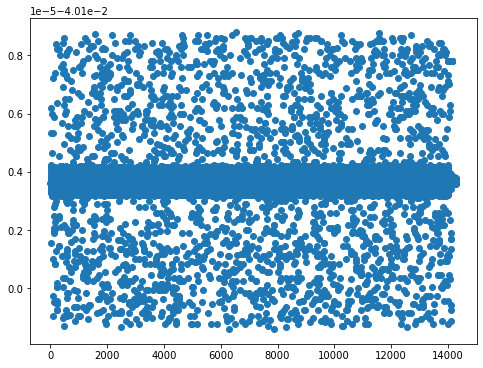

In [14]:
plt.scatter(x_axis, data[0,:,0])

In [15]:
data

array([[[-0.04009638, -0.04131178, -0.04226808, ...,  0.01324532,
          0.02055552,  0.02728652],
        [-0.0400963 , -0.0413117 , -0.0422681 , ...,  0.01324534,
          0.0205556 ,  0.0272869 ],
        [-0.04009629, -0.04131169, -0.04226809, ...,  0.01324531,
          0.02055561,  0.02728691],
        ...,
        [-0.04009638, -0.04131178, -0.04226818, ...,  0.01324525,
          0.02055552,  0.02728682],
        [-0.04009629, -0.04131169, -0.04226809, ...,  0.01324533,
          0.02055561,  0.02728691],
        [-0.04009626, -0.04131166, -0.04226806, ...,  0.01324539,
          0.02055564,  0.02728694]]])

## FOM data type : FOM_data = np.array[param, time, node, var]

In [16]:
FOM_data = np.zeros((num_param, num_time, num_node, num_var))

for i in range(num_var):
    for j in range(num_node):
        for k in range(num_param):
            for l in range(num_time):
                temp = l+k*num_time
                #print(l, k, temp)
                FOM_data[k,l,j,i]=data[i,j,temp]
                
FOM_data.shape

(10, 800, 14300, 1)

In [17]:
x_axis

array([0.00000000e+00, 1.00006993e+00, 2.00013987e+00, ...,
       1.42979999e+04, 1.42989999e+04, 1.43000000e+04])

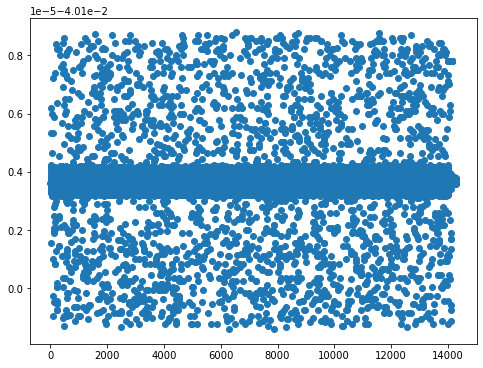

In [18]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

In [19]:
# validate
print(FOM_data[0,0,0,0])
print(FOM_data[1,0,0,0])
print(FOM_data[0,1,0,0])
print(FOM_data[0,0,2,0])

-0.0400963761125
-0.0489409761125
-0.0413117761125
-0.040096287525


In [20]:
maximum = np.amax(FOM_data)
minimum = np.amin(FOM_data)
mean = np.mean(FOM_data)
AT = maximum-minimum

In [21]:
print(maximum)
print(minimum)
print(mean)
print(AT)

0.14354273825
-0.13646576825
-1.5900257024002243e-20
0.2800085065


In [22]:
FOM_data = FOM_data-mean
FOM_data = FOM_data/AT

In [23]:
print(np.max(FOM_data))
print(np.min(FOM_data))

0.5126370625100992
-0.48736293748990095


In [24]:
FOM_data.shape

(10, 800, 14300, 1)

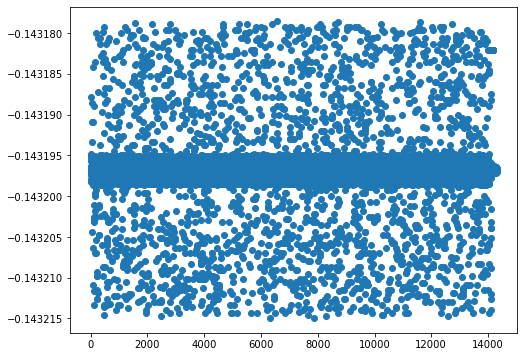

In [25]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

# Level 1, SVAE (spatial VAE)

In [26]:
#Lv1_input = np.zeros((num_param*num_time, num_node, num_var))
# Lv1_input = (num_param x num_time, num_node, num_var)

Lv1_input = FOM_data.reshape(-1, num_node, num_var)
Lv1_input.shape
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

(8000, 14300, 1)

In [27]:
#validate

Lv1_input[200,0,0]
Lv1_input_shape_decoder = Lv1_input.shape[1]

In [28]:
Lv1_input_shape = Lv1_input.shape[1:]

In [29]:
print(Lv1_input.shape)
print(Lv1_input_shape)

(8000, 14300, 1)
(14300, 1)


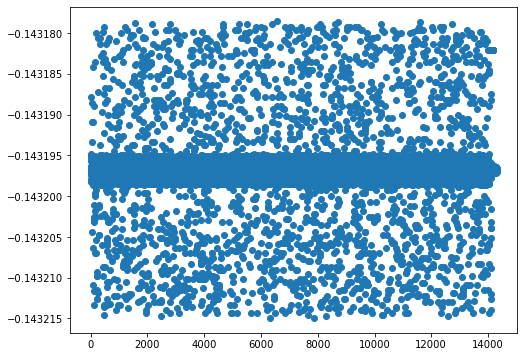

In [30]:
plt.scatter(x_axis, Lv1_input[0,:,0])

# Encoder

In [31]:
def encoder():
    x_input=layers.Input(shape=Lv1_input_shape)
    #x=layers.ZeroPadding1D(2)(x_input)
    
    x=layers.Conv1D(32, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x_input)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(64, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)   
    
    x=layers.Conv1D(128, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Flatten()(x)
    x=layers.Dense(Lv1_latent_dim)(x)
    
    #mu=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    #var=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    #var=layers.Activation(tf.nn.softplus)(var) # var > 0
    
    #eps = tf.random.normal(shape=[Lv1_latent_dim], mean=0.0, stddev=1.0)
    #z = eps * tf.math.sqrt(var) + mu
    
    en_coder = tf.keras.models.Model(x_input, [x], name="ENCODER")
    return en_coder

Encoder=encoder()
Encoder.summary()
#tf.keras.utils.plot_model(Encoder, show_shapes=True)

Model: "ENCODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14300, 1)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 14300, 32)         192       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14300, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 14300, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14300, 64)         10304     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14300, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14300, 64)         0   

# Decoder

In [32]:
print(Lv1_latent_dim)
print(Lv1_input_shape_decoder)

64
14300


In [33]:
def decoder():
    z_input=layers.Input(shape=(Lv1_latent_dim))
    
    z=layers.Dense(Lv1_input_shape_decoder*Lv1_latent_dim, kernel_initializer='glorot_uniform')(z_input)
    z=layers.LeakyReLU(alpha=0.3)(z)
    
    z=layers.Reshape([Lv1_input_shape_decoder,Lv1_latent_dim])(z)
        
    z=layers.Conv1DTranspose(128, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(64, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(32, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)    
    
    z=layers.Dense(num_var)(z)
    
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    
    #z_mu=layers.Dense(num_var, kernel_initializer='glorot_uniform')(z)
    #mu_prime=layers.Activation('tanh')(z_mu)
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    
    #z_var=layers.Dense(num_var, kernel_initializer='glorot_uniform')(z)
    #var_prime=layers.Activation(tf.nn.softplus)(z_var) # var > 0
    
    ## I guess the 
    
    
    de_coder = tf.keras.models.Model(z_input, [z], name="DECODER")
    return de_coder

Decoder=decoder()
Decoder.summary()
#tf.keras.utils.plot_model(Decoder, show_shapes=True)

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 915200)            59488000  
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 915200)            0         
_________________________________________________________________
reshape (Reshape)            (None, 14300, 64)         0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 14300, 128)        32896     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14300, 128)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14300, 128)        0   

# loss computation

In [34]:
def compute_loss(real_img, fake_img):
    
    reconstruction_error = tf.math.reduce_mean(tf.math.reduce_sum(tf.math.square(real_img) + tf.math.square(fake_img)))
    
    
    loss = reconstruction_error
    
    return loss

# VAE

In [35]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, ENCODER, DECODER):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.ENCODER = ENCODER
        self.DECODER = DECODER
        
    def compile(self, opt, loss):
        super(VAE, self).compile()
        self.opt = opt
        self.loss = loss

    def train_step(self, real_img):
        if isinstance(data, tuple):
            real_img = real_img[0]
            
        with tf.GradientTape() as tape:
            # encoding
            latent_space = self.ENCODER(real_img, training=True)
            
            # decoding
            fake_img = self.DECODER(latent_space, training=True)
            
            # loss calculation
            loss = self.loss(real_img, fake_img)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}


# Save Model

In [36]:
class SaveModel(tf.keras.callbacks.Callback):
    def __init__(self, num_iter=n_epochs, latent_dim=Lv1_latent_dim):
        self.num_iter = num_iter
        self.latent_dim = Lv1_latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        if((epoch+1)%1000==0):
            if((epoch+1)%1000==0):          
                filename1 = 'test_constrained_ae/decoder_%dbatchnorm.h5' % (epoch+1)
                filename2 = 'test_constrained_ae/encoder_%dbatchnorm.h5' % (epoch+1)
                
                Decoder.save(filename1)
                Encoder.save(filename2)

In [37]:
print(Lv1_input.shape)
print(type(Lv1_input))

(8000, 14300, 1)
<class 'numpy.ndarray'>


# Warm up

In [38]:
beta = K.variable(0.)
N_t = int(n_epochs * 0.25)

class WarmUp(tf.keras.callbacks.Callback):
    def __init__(self, beta):
        self.beta = beta
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < N_t:
            K.set_value(self.beta, epoch / N_t)
        else:
            K.set_value(self.beta, 1)


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.99)

cbk1 = SaveModel(num_iter=n_epochs,latent_dim=Lv1_latent_dim)
cbk2 = WarmUp(beta)

#with strategy.scope():
vae = VAE(latent_dim=Lv1_latent_dim, ENCODER=Encoder, DECODER=Decoder)
vae.compile(opt=opt, loss=losses.MeanSquaredError())

start = time.time()
vae.fit(Lv1_input, batch_size=batch_size, epochs=n_epochs, callbacks=[cbk1, cbk2])
end = time.time()

print(end-start)

Epoch 1/20000
800/800 [==============================] - 299s 31ms/step - loss: 0.0048
Epoch 2/20000
800/800 [==============================] - 25s 31ms/step - loss: 0.0020
Epoch 3/20000
800/800 [==============================] - 25s 31ms/step - loss: 0.0017
Epoch 4/20000
800/800 [==============================] - 25s 31ms/step - loss: 0.0016
Epoch 5/20000
800/800 [==============================] - 25s 31ms/step - loss: 0.0015
Epoch 6/20000
800/800 [==============================] - 25s 31ms/step - loss: 0.0014
Epoch 7/20000
800/800 [==============================] - 25s 31ms/step - loss: 0.0013
Epoch 8/20000
800/800 [==============================] - 25s 31ms/step - loss: 0.0013
Epoch 9/20000
800/800 [==============================] - 25s 31ms/step - loss: 0.0012
Epoch 10/20000
800/800 [==============================] - 25s 31ms/step - loss: 0.0012
Epoch 11/20000
800/800 [==============================] - 25s 31ms/step - loss: 0.0012
Epoch 12/20000
800/800 [===========================

800/800 [==============================] - 25s 31ms/step - loss: 9.3986e-04
Epoch 91/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.3899e-04
Epoch 92/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.3815e-04
Epoch 93/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.3717e-04
Epoch 94/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.3651e-04
Epoch 95/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.3534e-04
Epoch 96/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.3518e-04
Epoch 97/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.3453e-04
Epoch 98/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.3405e-04
Epoch 99/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.3381e-04
Epoch 100/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.3331e-04
Epoch 101/200

800/800 [==============================] - 25s 31ms/step - loss: 9.1331e-04
Epoch 180/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.1280e-04
Epoch 181/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.1333e-04
Epoch 182/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.1241e-04
Epoch 183/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.1198e-04
Epoch 184/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.1253e-04
Epoch 185/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.1268e-04
Epoch 186/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.1184e-04
Epoch 187/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.1205e-04
Epoch 188/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.1281e-04
Epoch 189/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.1144e-04
Epoc

800/800 [==============================] - 25s 31ms/step - loss: 9.0607e-04
Epoch 269/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0597e-04
Epoch 270/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0687e-04
Epoch 271/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0719e-04
Epoch 272/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0705e-04
Epoch 273/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0645e-04
Epoch 274/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0730e-04
Epoch 275/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0545e-04
Epoch 276/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0643e-04
Epoch 277/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0565e-04
Epoch 278/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0579e-04
Epoc

800/800 [==============================] - 25s 31ms/step - loss: 9.0320e-04
Epoch 358/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0345e-04
Epoch 359/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0313e-04
Epoch 360/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0360e-04
Epoch 361/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0354e-04
Epoch 362/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0252e-04
Epoch 363/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0301e-04
Epoch 364/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0323e-04
Epoch 365/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0225e-04
Epoch 366/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0279e-04
Epoch 367/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0214e-04
Epoc

800/800 [==============================] - 25s 31ms/step - loss: 9.0170e-04
Epoch 447/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0094e-04
Epoch 448/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0149e-04
Epoch 449/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0067e-04
Epoch 450/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0105e-04
Epoch 451/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0086e-04
Epoch 452/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0043e-04
Epoch 453/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0093e-04
Epoch 454/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0152e-04
Epoch 455/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0116e-04
Epoch 456/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0153e-04
Epoc

800/800 [==============================] - 25s 31ms/step - loss: 9.0037e-04
Epoch 536/20000
800/800 [==============================] - 25s 31ms/step - loss: 9.0001e-04
Epoch 537/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9914e-04
Epoch 538/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9893e-04
Epoch 539/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9902e-04
Epoch 540/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9954e-04
Epoch 541/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9902e-04
Epoch 542/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9948e-04
Epoch 543/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9934e-04
Epoch 544/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9933e-04
Epoch 545/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9972e-04
Epoc

800/800 [==============================] - 25s 31ms/step - loss: 8.9822e-04
Epoch 625/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9902e-04
Epoch 626/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9787e-04
Epoch 627/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9804e-04
Epoch 628/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9748e-04
Epoch 629/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9825e-04
Epoch 630/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9735e-04
Epoch 631/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9838e-04
Epoch 632/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9784e-04
Epoch 633/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9794e-04
Epoch 634/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9842e-04
Epoc

800/800 [==============================] - 25s 31ms/step - loss: 8.9672e-04
Epoch 714/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9626e-04
Epoch 715/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9725e-04
Epoch 716/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9661e-04
Epoch 717/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9617e-04
Epoch 718/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9642e-04
Epoch 719/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9614e-04
Epoch 720/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9694e-04
Epoch 721/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9689e-04
Epoch 722/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9662e-04
Epoch 723/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9639e-04
Epoc

800/800 [==============================] - 25s 31ms/step - loss: 8.9591e-04
Epoch 803/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9566e-04
Epoch 804/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9556e-04
Epoch 805/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9608e-04
Epoch 806/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9549e-04
Epoch 807/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9618e-04
Epoch 808/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9639e-04
Epoch 809/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9593e-04
Epoch 810/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9577e-04
Epoch 811/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9544e-04
Epoch 812/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9526e-04
Epoc

800/800 [==============================] - 25s 31ms/step - loss: 8.9446e-04
Epoch 892/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9486e-04
Epoch 893/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9510e-04
Epoch 894/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9542e-04
Epoch 895/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9400e-04
Epoch 896/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9504e-04
Epoch 897/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9528e-04
Epoch 898/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9434e-04
Epoch 899/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9537e-04
Epoch 900/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9488e-04
Epoch 901/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9449e-04
Epoc

800/800 [==============================] - 25s 31ms/step - loss: 8.9373e-04
Epoch 981/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9430e-04
Epoch 982/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9421e-04
Epoch 983/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9435e-04
Epoch 984/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9389e-04
Epoch 985/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9439e-04
Epoch 986/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9360e-04
Epoch 987/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9418e-04
Epoch 988/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9490e-04
Epoch 989/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9360e-04
Epoch 990/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9408e-04
Epoc

800/800 [==============================] - 25s 31ms/step - loss: 8.9323e-04
Epoch 1065/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9318e-04
Epoch 1066/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9321e-04
Epoch 1067/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9348e-04
Epoch 1068/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9351e-04
Epoch 1069/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9408e-04
Epoch 1070/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9290e-04
Epoch 1071/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9345e-04
Epoch 1072/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9295e-04
Epoch 1073/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9364e-04
Epoch 1074/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.937

800/800 [==============================] - 25s 31ms/step - loss: 8.9212e-04
Epoch 1153/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9233e-04
Epoch 1154/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9304e-04
Epoch 1155/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9382e-04
Epoch 1156/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9209e-04
Epoch 1157/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9285e-04
Epoch 1158/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9260e-04
Epoch 1159/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9217e-04
Epoch 1160/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9302e-04
Epoch 1161/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9243e-04
Epoch 1162/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.916

800/800 [==============================] - 25s 31ms/step - loss: 8.9202e-04
Epoch 1241/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9197e-04
Epoch 1242/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9254e-04
Epoch 1243/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9231e-04
Epoch 1244/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9210e-04
Epoch 1245/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9171e-04
Epoch 1246/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9232e-04
Epoch 1247/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9168e-04
Epoch 1248/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9177e-04
Epoch 1249/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9210e-04
Epoch 1250/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.916

800/800 [==============================] - 25s 31ms/step - loss: 8.9117e-04
Epoch 1329/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9235e-04
Epoch 1330/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9158e-04
Epoch 1331/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9129e-04
Epoch 1332/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9077e-04
Epoch 1333/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9145e-04
Epoch 1334/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9238e-04
Epoch 1335/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9163e-04
Epoch 1336/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9174e-04
Epoch 1337/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9136e-04
Epoch 1338/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.914

800/800 [==============================] - 25s 31ms/step - loss: 8.9121e-04
Epoch 1417/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9040e-04
Epoch 1418/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9124e-04
Epoch 1419/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9174e-04
Epoch 1420/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9100e-04
Epoch 1421/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9114e-04
Epoch 1422/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9150e-04
Epoch 1423/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9023e-04
Epoch 1424/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9124e-04
Epoch 1425/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9110e-04
Epoch 1426/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.905

800/800 [==============================] - 25s 31ms/step - loss: 8.9183e-04
Epoch 1505/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9108e-04
Epoch 1506/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9016e-04
Epoch 1507/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9071e-04
Epoch 1508/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9074e-04
Epoch 1509/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9054e-04
Epoch 1510/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9088e-04
Epoch 1511/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9080e-04
Epoch 1512/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9089e-04
Epoch 1513/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9048e-04
Epoch 1514/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.904

800/800 [==============================] - 25s 31ms/step - loss: 8.9051e-04
Epoch 1593/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9020e-04
Epoch 1594/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9028e-04
Epoch 1595/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9041e-04
Epoch 1596/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8982e-04
Epoch 1597/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9013e-04
Epoch 1598/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9046e-04
Epoch 1599/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9031e-04
Epoch 1600/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9062e-04
Epoch 1601/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9040e-04
Epoch 1602/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.904

800/800 [==============================] - 25s 31ms/step - loss: 8.9034e-04
Epoch 1681/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8979e-04
Epoch 1682/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8986e-04
Epoch 1683/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9027e-04
Epoch 1684/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9105e-04
Epoch 1685/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9045e-04
Epoch 1686/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9053e-04
Epoch 1687/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8996e-04
Epoch 1688/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9054e-04
Epoch 1689/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8980e-04
Epoch 1690/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.898

800/800 [==============================] - 25s 31ms/step - loss: 8.8972e-04
Epoch 1769/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8992e-04
Epoch 1770/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8994e-04
Epoch 1771/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9014e-04
Epoch 1772/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9082e-04
Epoch 1773/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9004e-04
Epoch 1774/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8963e-04
Epoch 1775/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8971e-04
Epoch 1776/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8991e-04
Epoch 1777/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8999e-04
Epoch 1778/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.895

800/800 [==============================] - 25s 31ms/step - loss: 8.8986e-04
Epoch 1857/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8946e-04
Epoch 1858/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8973e-04
Epoch 1859/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8950e-04
Epoch 1860/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8987e-04
Epoch 1861/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8905e-04
Epoch 1862/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8987e-04
Epoch 1863/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8945e-04
Epoch 1864/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8936e-04
Epoch 1865/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8958e-04
Epoch 1866/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.896

800/800 [==============================] - 25s 31ms/step - loss: 8.8900e-04
Epoch 1945/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8908e-04
Epoch 1946/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9019e-04
Epoch 1947/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8985e-04
Epoch 1948/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8980e-04
Epoch 1949/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8943e-04
Epoch 1950/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8989e-04
Epoch 1951/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9010e-04
Epoch 1952/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8920e-04
Epoch 1953/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8957e-04
Epoch 1954/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.893

800/800 [==============================] - 25s 31ms/step - loss: 8.8947e-04
Epoch 2029/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8982e-04
Epoch 2030/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8875e-04
Epoch 2031/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8894e-04
Epoch 2032/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8882e-04
Epoch 2033/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8937e-04
Epoch 2034/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8970e-04
Epoch 2035/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8955e-04
Epoch 2036/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.9008e-04
Epoch 2037/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8857e-04
Epoch 2038/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.890

800/800 [==============================] - 25s 31ms/step - loss: 8.8964e-04
Epoch 2117/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8947e-04
Epoch 2118/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8935e-04
Epoch 2119/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8969e-04
Epoch 2120/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8942e-04
Epoch 2121/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8900e-04
Epoch 2122/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8880e-04
Epoch 2123/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8861e-04
Epoch 2124/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8961e-04
Epoch 2125/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8927e-04
Epoch 2126/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.891

800/800 [==============================] - 25s 31ms/step - loss: 8.8927e-04
Epoch 2205/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8914e-04
Epoch 2206/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8921e-04
Epoch 2207/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8929e-04
Epoch 2208/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8893e-04
Epoch 2209/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8905e-04
Epoch 2210/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8876e-04
Epoch 2211/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8902e-04
Epoch 2212/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8857e-04
Epoch 2213/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8954e-04
Epoch 2214/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.888

800/800 [==============================] - 25s 31ms/step - loss: 8.8894e-04
Epoch 2293/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8881e-04
Epoch 2294/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8840e-04
Epoch 2295/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8910e-04
Epoch 2296/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8862e-04
Epoch 2297/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8876e-04
Epoch 2298/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8872e-04
Epoch 2299/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8858e-04
Epoch 2300/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8886e-04
Epoch 2301/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8950e-04
Epoch 2302/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.893

800/800 [==============================] - 25s 31ms/step - loss: 8.8889e-04
Epoch 2381/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8891e-04
Epoch 2382/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8933e-04
Epoch 2383/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8833e-04
Epoch 2384/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8892e-04
Epoch 2385/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8853e-04
Epoch 2386/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8860e-04
Epoch 2387/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8793e-04
Epoch 2388/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8856e-04
Epoch 2389/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8793e-04
Epoch 2390/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.884

800/800 [==============================] - 25s 31ms/step - loss: 8.8829e-04
Epoch 2469/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8852e-04
Epoch 2470/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8882e-04
Epoch 2471/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8877e-04
Epoch 2472/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8758e-04
Epoch 2473/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8883e-04
Epoch 2474/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8820e-04
Epoch 2475/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8865e-04
Epoch 2476/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8839e-04
Epoch 2477/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8882e-04
Epoch 2478/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.881

800/800 [==============================] - 25s 31ms/step - loss: 8.8844e-04
Epoch 2557/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8807e-04
Epoch 2558/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8800e-04
Epoch 2559/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8856e-04
Epoch 2560/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8837e-04
Epoch 2561/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8773e-04
Epoch 2562/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8923e-04
Epoch 2563/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8777e-04
Epoch 2564/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8954e-04
Epoch 2565/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8824e-04
Epoch 2566/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.883

800/800 [==============================] - 25s 31ms/step - loss: 8.8764e-04
Epoch 2645/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8891e-04
Epoch 2646/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8718e-04
Epoch 2647/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8736e-04
Epoch 2648/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8769e-04
Epoch 2649/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8747e-04
Epoch 2650/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8771e-04
Epoch 2651/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8815e-04
Epoch 2652/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8871e-04
Epoch 2653/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8873e-04
Epoch 2654/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.882

800/800 [==============================] - 25s 31ms/step - loss: 8.8806e-04
Epoch 2733/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8762e-04
Epoch 2734/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8764e-04
Epoch 2735/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8779e-04
Epoch 2736/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8781e-04
Epoch 2737/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8809e-04
Epoch 2738/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8800e-04
Epoch 2739/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8776e-04
Epoch 2740/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8821e-04
Epoch 2741/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8759e-04
Epoch 2742/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.876

800/800 [==============================] - 25s 31ms/step - loss: 8.8760e-04
Epoch 2821/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8772e-04
Epoch 2822/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8749e-04
Epoch 2823/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8778e-04
Epoch 2824/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8801e-04
Epoch 2825/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8803e-04
Epoch 2826/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8674e-04
Epoch 2827/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8727e-04
Epoch 2828/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8791e-04
Epoch 2829/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8742e-04
Epoch 2830/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.878

800/800 [==============================] - 25s 31ms/step - loss: 8.8689e-04
Epoch 2909/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8710e-04
Epoch 2910/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8699e-04
Epoch 2911/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8765e-04
Epoch 2912/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8821e-04
Epoch 2913/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8755e-04
Epoch 2914/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8729e-04
Epoch 2915/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8717e-04
Epoch 2916/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8746e-04
Epoch 2917/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8754e-04
Epoch 2918/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.874

800/800 [==============================] - 25s 31ms/step - loss: 8.8693e-04
Epoch 2997/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8685e-04
Epoch 2998/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8743e-04
Epoch 2999/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8731e-04
Epoch 3000/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8737e-04
Epoch 3001/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8663e-04
Epoch 3002/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8724e-04
Epoch 3003/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8650e-04
Epoch 3004/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8804e-04
Epoch 3005/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8754e-04
Epoch 3006/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.874

800/800 [==============================] - 25s 31ms/step - loss: 8.8719e-04
Epoch 3081/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8660e-04
Epoch 3082/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8745e-04
Epoch 3083/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8646e-04
Epoch 3084/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8768e-04
Epoch 3085/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8654e-04
Epoch 3086/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8756e-04
Epoch 3087/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8716e-04
Epoch 3088/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8624e-04
Epoch 3089/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8679e-04
Epoch 3090/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.866

800/800 [==============================] - 25s 31ms/step - loss: 8.8699e-04
Epoch 3169/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8648e-04
Epoch 3170/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8714e-04
Epoch 3171/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8661e-04
Epoch 3172/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8617e-04
Epoch 3173/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8685e-04
Epoch 3174/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8699e-04
Epoch 3175/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8718e-04
Epoch 3176/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8639e-04
Epoch 3177/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8704e-04
Epoch 3178/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.867

800/800 [==============================] - 25s 31ms/step - loss: 8.8634e-04
Epoch 3257/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8695e-04
Epoch 3258/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8660e-04
Epoch 3259/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8694e-04
Epoch 3260/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8682e-04
Epoch 3261/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8756e-04
Epoch 3262/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8708e-04
Epoch 3263/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8726e-04
Epoch 3264/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8668e-04
Epoch 3265/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8626e-04
Epoch 3266/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.866

800/800 [==============================] - 25s 31ms/step - loss: 8.8685e-04
Epoch 3345/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8688e-04
Epoch 3346/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8637e-04
Epoch 3347/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8615e-04
Epoch 3348/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8661e-04
Epoch 3349/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8642e-04
Epoch 3350/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8639e-04
Epoch 3351/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8605e-04
Epoch 3352/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8622e-04
Epoch 3353/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8674e-04
Epoch 3354/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.867

800/800 [==============================] - 25s 31ms/step - loss: 8.8602e-04
Epoch 3433/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8653e-04
Epoch 3434/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8652e-04
Epoch 3435/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8651e-04
Epoch 3436/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8652e-04
Epoch 3437/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8693e-04
Epoch 3438/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8675e-04
Epoch 3439/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8615e-04
Epoch 3440/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8616e-04
Epoch 3441/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8620e-04
Epoch 3442/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.871

800/800 [==============================] - 25s 31ms/step - loss: 8.8600e-04
Epoch 3521/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8630e-04
Epoch 3522/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8700e-04
Epoch 3523/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8675e-04
Epoch 3524/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8606e-04
Epoch 3525/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8663e-04
Epoch 3526/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8548e-04
Epoch 3527/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8573e-04
Epoch 3528/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8602e-04
Epoch 3529/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8566e-04
Epoch 3530/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.863

800/800 [==============================] - 25s 31ms/step - loss: 8.8621e-04
Epoch 3609/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8605e-04
Epoch 3610/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8600e-04
Epoch 3611/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8616e-04
Epoch 3612/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8570e-04
Epoch 3613/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8662e-04
Epoch 3614/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8662e-04
Epoch 3615/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8602e-04
Epoch 3616/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8668e-04
Epoch 3617/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8593e-04
Epoch 3618/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.876

800/800 [==============================] - 25s 31ms/step - loss: 8.8582e-04
Epoch 3697/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8571e-04
Epoch 3698/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8630e-04
Epoch 3699/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8688e-04
Epoch 3700/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8629e-04
Epoch 3701/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8575e-04
Epoch 3702/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8626e-04
Epoch 3703/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8696e-04
Epoch 3704/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8588e-04
Epoch 3705/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8607e-04
Epoch 3706/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.857

800/800 [==============================] - 25s 31ms/step - loss: 8.8611e-04
Epoch 3785/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8605e-04
Epoch 3786/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8589e-04
Epoch 3787/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8646e-04
Epoch 3788/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8631e-04
Epoch 3789/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8627e-04
Epoch 3790/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8636e-04
Epoch 3791/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8555e-04
Epoch 3792/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8606e-04
Epoch 3793/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8641e-04
Epoch 3794/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.860

800/800 [==============================] - 25s 31ms/step - loss: 8.8644e-04
Epoch 3873/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8605e-04
Epoch 3874/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8549e-04
Epoch 3875/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8628e-04
Epoch 3876/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8627e-04
Epoch 3877/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8671e-04
Epoch 3878/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8620e-04
Epoch 3879/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8611e-04
Epoch 3880/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8657e-04
Epoch 3881/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8593e-04
Epoch 3882/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.862

800/800 [==============================] - 25s 31ms/step - loss: 8.8688e-04
Epoch 3961/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8593e-04
Epoch 3962/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8539e-04
Epoch 3963/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8573e-04
Epoch 3964/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8655e-04
Epoch 3965/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8555e-04
Epoch 3966/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8631e-04
Epoch 3967/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8667e-04
Epoch 3968/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8570e-04
Epoch 3969/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8651e-04
Epoch 3970/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.857

800/800 [==============================] - 25s 31ms/step - loss: 8.8647e-04
Epoch 4045/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8560e-04
Epoch 4046/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8650e-04
Epoch 4047/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8558e-04
Epoch 4048/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8583e-04
Epoch 4049/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8594e-04
Epoch 4050/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8570e-04
Epoch 4051/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8618e-04
Epoch 4052/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8620e-04
Epoch 4053/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8629e-04
Epoch 4054/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.861

800/800 [==============================] - 25s 31ms/step - loss: 8.8606e-04
Epoch 4133/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8592e-04
Epoch 4134/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8620e-04
Epoch 4135/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8639e-04
Epoch 4136/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8539e-04
Epoch 4137/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8639e-04
Epoch 4138/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8604e-04
Epoch 4139/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8645e-04
Epoch 4140/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8642e-04
Epoch 4141/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8632e-04
Epoch 4142/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.860

800/800 [==============================] - 25s 31ms/step - loss: 8.8590e-04
Epoch 4221/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8597e-04
Epoch 4222/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8546e-04
Epoch 4223/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8544e-04
Epoch 4224/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8600e-04
Epoch 4225/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8571e-04
Epoch 4226/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8634e-04
Epoch 4227/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8585e-04
Epoch 4228/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8554e-04
Epoch 4229/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8605e-04
Epoch 4230/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.864

800/800 [==============================] - 25s 31ms/step - loss: 8.8612e-04
Epoch 4309/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8574e-04
Epoch 4310/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8561e-04
Epoch 4311/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8533e-04
Epoch 4312/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8576e-04
Epoch 4313/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8582e-04
Epoch 4314/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8587e-04
Epoch 4315/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8553e-04
Epoch 4316/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8518e-04
Epoch 4317/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8558e-04
Epoch 4318/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.860

800/800 [==============================] - 25s 31ms/step - loss: 8.8569e-04
Epoch 4397/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8555e-04
Epoch 4398/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8569e-04
Epoch 4399/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8600e-04
Epoch 4400/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8597e-04
Epoch 4401/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8581e-04
Epoch 4402/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8554e-04
Epoch 4403/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8543e-04
Epoch 4404/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8554e-04
Epoch 4405/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8588e-04
Epoch 4406/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.860

800/800 [==============================] - 25s 31ms/step - loss: 8.8666e-04
Epoch 4485/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8637e-04
Epoch 4486/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8577e-04
Epoch 4487/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8571e-04
Epoch 4488/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8605e-04
Epoch 4489/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8590e-04
Epoch 4490/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8569e-04
Epoch 4491/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8563e-04
Epoch 4492/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8674e-04
Epoch 4493/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8560e-04
Epoch 4494/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.855

800/800 [==============================] - 25s 31ms/step - loss: 8.8582e-04
Epoch 4573/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8625e-04
Epoch 4574/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8534e-04
Epoch 4575/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8578e-04
Epoch 4576/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8581e-04
Epoch 4577/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8524e-04
Epoch 4578/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8615e-04
Epoch 4579/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8615e-04
Epoch 4580/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8674e-04
Epoch 4581/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8585e-04
Epoch 4582/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.854

800/800 [==============================] - 25s 31ms/step - loss: 8.8565e-04
Epoch 4661/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8593e-04
Epoch 4662/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8574e-04
Epoch 4663/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8577e-04
Epoch 4664/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8648e-04
Epoch 4665/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8613e-04
Epoch 4666/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8517e-04
Epoch 4667/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8518e-04
Epoch 4668/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8549e-04
Epoch 4669/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8528e-04
Epoch 4670/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.851

800/800 [==============================] - 25s 31ms/step - loss: 8.8606e-04
Epoch 4749/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8559e-04
Epoch 4750/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8534e-04
Epoch 4751/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8560e-04
Epoch 4752/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8545e-04
Epoch 4753/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8562e-04
Epoch 4754/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8493e-04
Epoch 4755/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8582e-04
Epoch 4756/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8569e-04
Epoch 4757/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8578e-04
Epoch 4758/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.851

800/800 [==============================] - 25s 31ms/step - loss: 8.8688e-04
Epoch 4837/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8538e-04
Epoch 4838/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8555e-04
Epoch 4839/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8527e-04
Epoch 4840/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8556e-04
Epoch 4841/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8633e-04
Epoch 4842/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8575e-04
Epoch 4843/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8557e-04
Epoch 4844/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8597e-04
Epoch 4845/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8665e-04
Epoch 4846/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.855

800/800 [==============================] - 25s 31ms/step - loss: 8.8535e-04
Epoch 4925/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8564e-04
Epoch 4926/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8538e-04
Epoch 4927/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8568e-04
Epoch 4928/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8573e-04
Epoch 4929/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8493e-04
Epoch 4930/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8509e-04
Epoch 4931/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8644e-04
Epoch 4932/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8560e-04
Epoch 4933/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8584e-04
Epoch 4934/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.854

800/800 [==============================] - 25s 31ms/step - loss: 8.8566e-04
Epoch 5009/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8561e-04
Epoch 5010/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8592e-04
Epoch 5011/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8619e-04
Epoch 5012/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8580e-04
Epoch 5013/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8598e-04
Epoch 5014/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8553e-04
Epoch 5015/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8582e-04
Epoch 5016/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8524e-04
Epoch 5017/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8620e-04
Epoch 5018/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.861

800/800 [==============================] - 25s 31ms/step - loss: 8.8584e-04
Epoch 5097/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8567e-04
Epoch 5098/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8550e-04
Epoch 5099/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8587e-04
Epoch 5100/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8533e-04
Epoch 5101/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8571e-04
Epoch 5102/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8539e-04
Epoch 5103/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8522e-04
Epoch 5104/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8559e-04
Epoch 5105/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8526e-04
Epoch 5106/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.863

800/800 [==============================] - 25s 31ms/step - loss: 8.8496e-04
Epoch 5185/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8527e-04
Epoch 5186/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8580e-04
Epoch 5187/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8563e-04
Epoch 5188/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8622e-04
Epoch 5189/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8588e-04
Epoch 5190/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8589e-04
Epoch 5191/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8552e-04
Epoch 5192/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8580e-04
Epoch 5193/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8520e-04
Epoch 5194/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.855

800/800 [==============================] - 25s 31ms/step - loss: 8.8622e-04
Epoch 5273/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8645e-04
Epoch 5274/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8535e-04
Epoch 5275/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8612e-04
Epoch 5276/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8549e-04
Epoch 5277/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8558e-04
Epoch 5278/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8603e-04
Epoch 5279/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8541e-04
Epoch 5280/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8547e-04
Epoch 5281/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8590e-04
Epoch 5282/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.856

800/800 [==============================] - 25s 31ms/step - loss: 8.8553e-04
Epoch 5361/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8550e-04
Epoch 5362/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8543e-04
Epoch 5363/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8566e-04
Epoch 5364/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8573e-04
Epoch 5365/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8587e-04
Epoch 5366/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8475e-04
Epoch 5367/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8580e-04
Epoch 5368/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8596e-04
Epoch 5369/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8541e-04
Epoch 5370/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.860

800/800 [==============================] - 25s 31ms/step - loss: 8.8632e-04
Epoch 5449/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8545e-04
Epoch 5450/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8582e-04
Epoch 5451/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8496e-04
Epoch 5452/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8572e-04
Epoch 5453/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8657e-04
Epoch 5454/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8529e-04
Epoch 5455/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8586e-04
Epoch 5456/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8582e-04
Epoch 5457/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8536e-04
Epoch 5458/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.855

800/800 [==============================] - 25s 31ms/step - loss: 8.8480e-04
Epoch 5537/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8608e-04
Epoch 5538/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8527e-04
Epoch 5539/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8495e-04
Epoch 5540/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8592e-04
Epoch 5541/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8571e-04
Epoch 5542/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8674e-04
Epoch 5543/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8473e-04
Epoch 5544/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8557e-04
Epoch 5545/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8551e-04
Epoch 5546/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.856

800/800 [==============================] - 25s 31ms/step - loss: 8.8567e-04
Epoch 5625/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8513e-04
Epoch 5626/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8567e-04
Epoch 5627/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8559e-04
Epoch 5628/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8557e-04
Epoch 5629/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8518e-04
Epoch 5630/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8543e-04
Epoch 5631/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8541e-04
Epoch 5632/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8581e-04
Epoch 5633/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8566e-04
Epoch 5634/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.853

800/800 [==============================] - 25s 31ms/step - loss: 8.8508e-04
Epoch 5713/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8603e-04
Epoch 5714/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8641e-04
Epoch 5715/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8592e-04
Epoch 5716/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8536e-04
Epoch 5717/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8563e-04
Epoch 5718/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8583e-04
Epoch 5719/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8621e-04
Epoch 5720/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8535e-04
Epoch 5721/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8558e-04
Epoch 5722/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.862

800/800 [==============================] - 25s 31ms/step - loss: 8.8527e-04
Epoch 5801/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8559e-04
Epoch 5802/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8579e-04
Epoch 5803/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8589e-04
Epoch 5804/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8449e-04
Epoch 5805/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8559e-04
Epoch 5806/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8499e-04
Epoch 5807/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8559e-04
Epoch 5808/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8580e-04
Epoch 5809/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8552e-04
Epoch 5810/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.855

800/800 [==============================] - 25s 31ms/step - loss: 8.8562e-04
Epoch 5889/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8554e-04
Epoch 5890/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8658e-04
Epoch 5891/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8499e-04
Epoch 5892/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8563e-04
Epoch 5893/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8559e-04
Epoch 5894/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8584e-04
Epoch 5895/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8559e-04
Epoch 5896/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8533e-04
Epoch 5897/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8553e-04
Epoch 5898/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.859

800/800 [==============================] - 25s 31ms/step - loss: 8.8506e-04
Epoch 5977/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8483e-04
Epoch 5978/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8527e-04
Epoch 5979/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8533e-04
Epoch 5980/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8546e-04
Epoch 5981/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8568e-04
Epoch 5982/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8629e-04
Epoch 5983/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8541e-04
Epoch 5984/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8508e-04
Epoch 5985/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8522e-04
Epoch 5986/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.858

800/800 [==============================] - 25s 31ms/step - loss: 8.8475e-04
Epoch 6061/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8566e-04
Epoch 6062/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8539e-04
Epoch 6063/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8540e-04
Epoch 6064/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8551e-04
Epoch 6065/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8573e-04
Epoch 6066/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8565e-04
Epoch 6067/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8661e-04
Epoch 6068/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8512e-04
Epoch 6069/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8540e-04
Epoch 6070/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.854

800/800 [==============================] - 25s 31ms/step - loss: 8.8501e-04
Epoch 6149/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8552e-04
Epoch 6150/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8517e-04
Epoch 6151/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8559e-04
Epoch 6152/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8599e-04
Epoch 6153/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8499e-04
Epoch 6154/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8547e-04
Epoch 6155/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8541e-04
Epoch 6156/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8502e-04
Epoch 6157/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8535e-04
Epoch 6158/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.857

800/800 [==============================] - 25s 31ms/step - loss: 8.8509e-04
Epoch 6237/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8544e-04
Epoch 6238/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8546e-04
Epoch 6239/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8539e-04
Epoch 6240/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8542e-04
Epoch 6241/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8474e-04
Epoch 6242/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8518e-04
Epoch 6243/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8560e-04
Epoch 6244/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8527e-04
Epoch 6245/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8542e-04
Epoch 6246/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.855

800/800 [==============================] - 25s 31ms/step - loss: 8.8544e-04
Epoch 6325/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8568e-04
Epoch 6326/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8493e-04
Epoch 6327/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8569e-04
Epoch 6328/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8494e-04
Epoch 6329/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8547e-04
Epoch 6330/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8543e-04
Epoch 6331/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8516e-04
Epoch 6332/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8499e-04
Epoch 6333/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8508e-04
Epoch 6334/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.850

800/800 [==============================] - 25s 31ms/step - loss: 8.8561e-04
Epoch 6413/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8475e-04
Epoch 6414/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8475e-04
Epoch 6415/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8595e-04
Epoch 6416/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8522e-04
Epoch 6417/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8590e-04
Epoch 6418/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8511e-04
Epoch 6419/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8530e-04
Epoch 6420/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8551e-04
Epoch 6421/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8509e-04
Epoch 6422/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.857

800/800 [==============================] - 25s 31ms/step - loss: 8.8502e-04
Epoch 6501/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8554e-04
Epoch 6502/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8492e-04
Epoch 6503/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8470e-04
Epoch 6504/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8528e-04
Epoch 6505/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8554e-04
Epoch 6506/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8519e-04
Epoch 6507/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8587e-04
Epoch 6508/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8500e-04
Epoch 6509/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8514e-04
Epoch 6510/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.859

800/800 [==============================] - 25s 31ms/step - loss: 8.8572e-04
Epoch 6589/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8486e-04
Epoch 6590/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8523e-04
Epoch 6591/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8589e-04
Epoch 6592/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8512e-04
Epoch 6593/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8589e-04
Epoch 6594/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8544e-04
Epoch 6595/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8609e-04
Epoch 6596/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8592e-04
Epoch 6597/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8566e-04
Epoch 6598/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.849

800/800 [==============================] - 25s 31ms/step - loss: 8.8540e-04
Epoch 6677/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8578e-04
Epoch 6678/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8586e-04
Epoch 6679/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8542e-04
Epoch 6680/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8584e-04
Epoch 6681/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8530e-04
Epoch 6682/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8538e-04
Epoch 6683/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8580e-04
Epoch 6684/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8565e-04
Epoch 6685/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8512e-04
Epoch 6686/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.856

800/800 [==============================] - 25s 31ms/step - loss: 8.8509e-04
Epoch 6765/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8507e-04
Epoch 6766/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8575e-04
Epoch 6767/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8612e-04
Epoch 6768/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8560e-04
Epoch 6769/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8533e-04
Epoch 6770/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8615e-04
Epoch 6771/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8551e-04
Epoch 6772/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8574e-04
Epoch 6773/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.8557e-04
Epoch 6774/20000
800/800 [==============================] - 25s 31ms/step - loss: 8.851

# Acquire latent vectors